In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

<IPython.core.display.Javascript object>


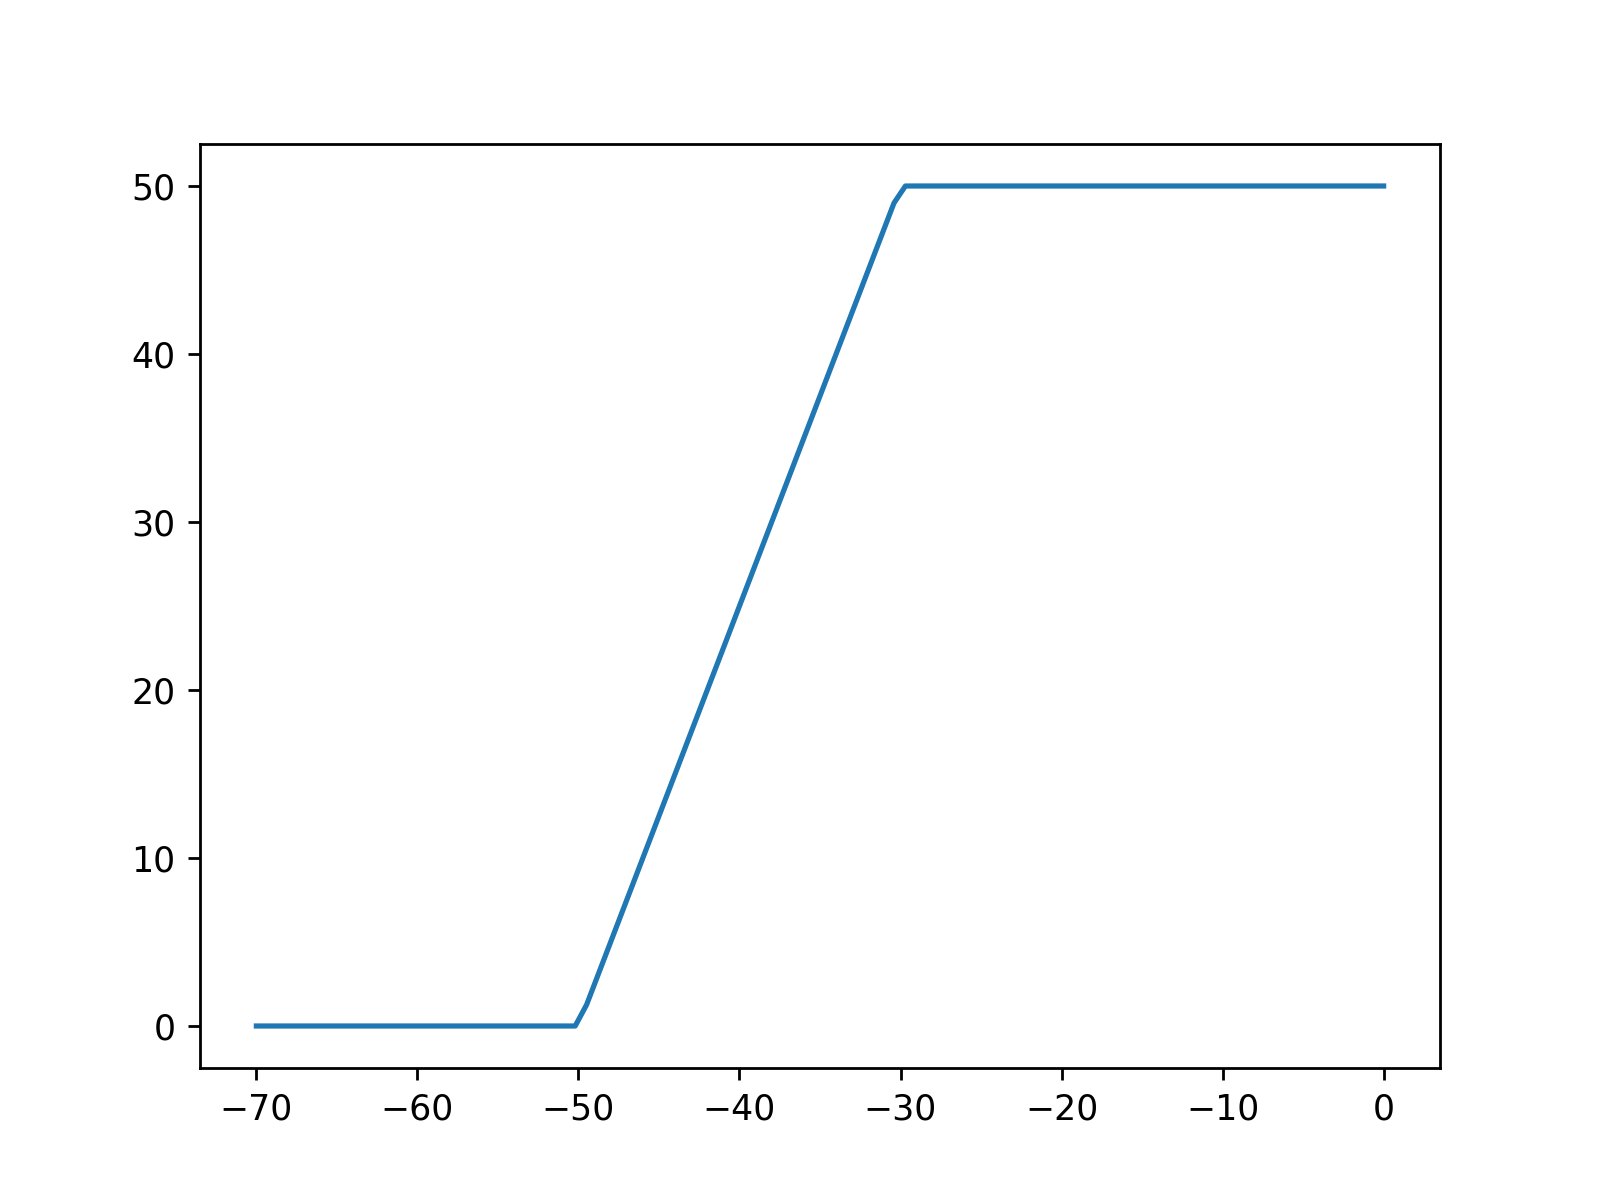

In [3]:
relu = lambda v, v_th=-50., v_peak=-30., peak_rate=50.: peak_rate / (v_peak - v_th) * np.minimum(v_peak - v_th, np.maximum(0., v - v_th))

v = np.linspace(-70., 0., 100)
plt.figure()
plt.plot(v, relu(v))

In [6]:
from collections import defaultdict

cell_peak_rate_dict = {'E': 50., 'FFE': 50.}
cell_v_rest_dict = {'E': -70.}  # mV
cell_tau_dict = {'E': 0.05}  # s
cell_r_inp_dict = {'E': 100.}  # MOhm = mV / nA

synapse_g_dict = defaultdict(dict)
synapse_g_dict['E']['FFE'] = 0.001 / cell_peak_rate_dict['FFE']  # nA / Hz

max_weight_dict = defaultdict(dict)
max_weight_dict['E']['FFE'] = 1.

synapse_v_reverse_dict = {'FFE': 0.}

synapse_tau_dict = defaultdict(dict)
synapse_tau_dict['E']['FFE'] = 0.01
num_cells_dict = {'E': 10, 'FFE': 10}

weight_init_dict = defaultdict(dict)
weight_init_dict['E']['FFE'] = np.random.uniform(0., max_weight_dict['E']['FFE'], (num_cells_dict['E'], num_cells_dict['FFE']))

num_input_patterns = 10
input_activities_dict = defaultdict(list)
for i in range(num_input_patterns):
    input_activities_dict['FFE'].append(np.random.uniform(0., cell_peak_rate_dict['FFE'], num_cells_dict['FFE']))

<IPython.core.display.Javascript object>


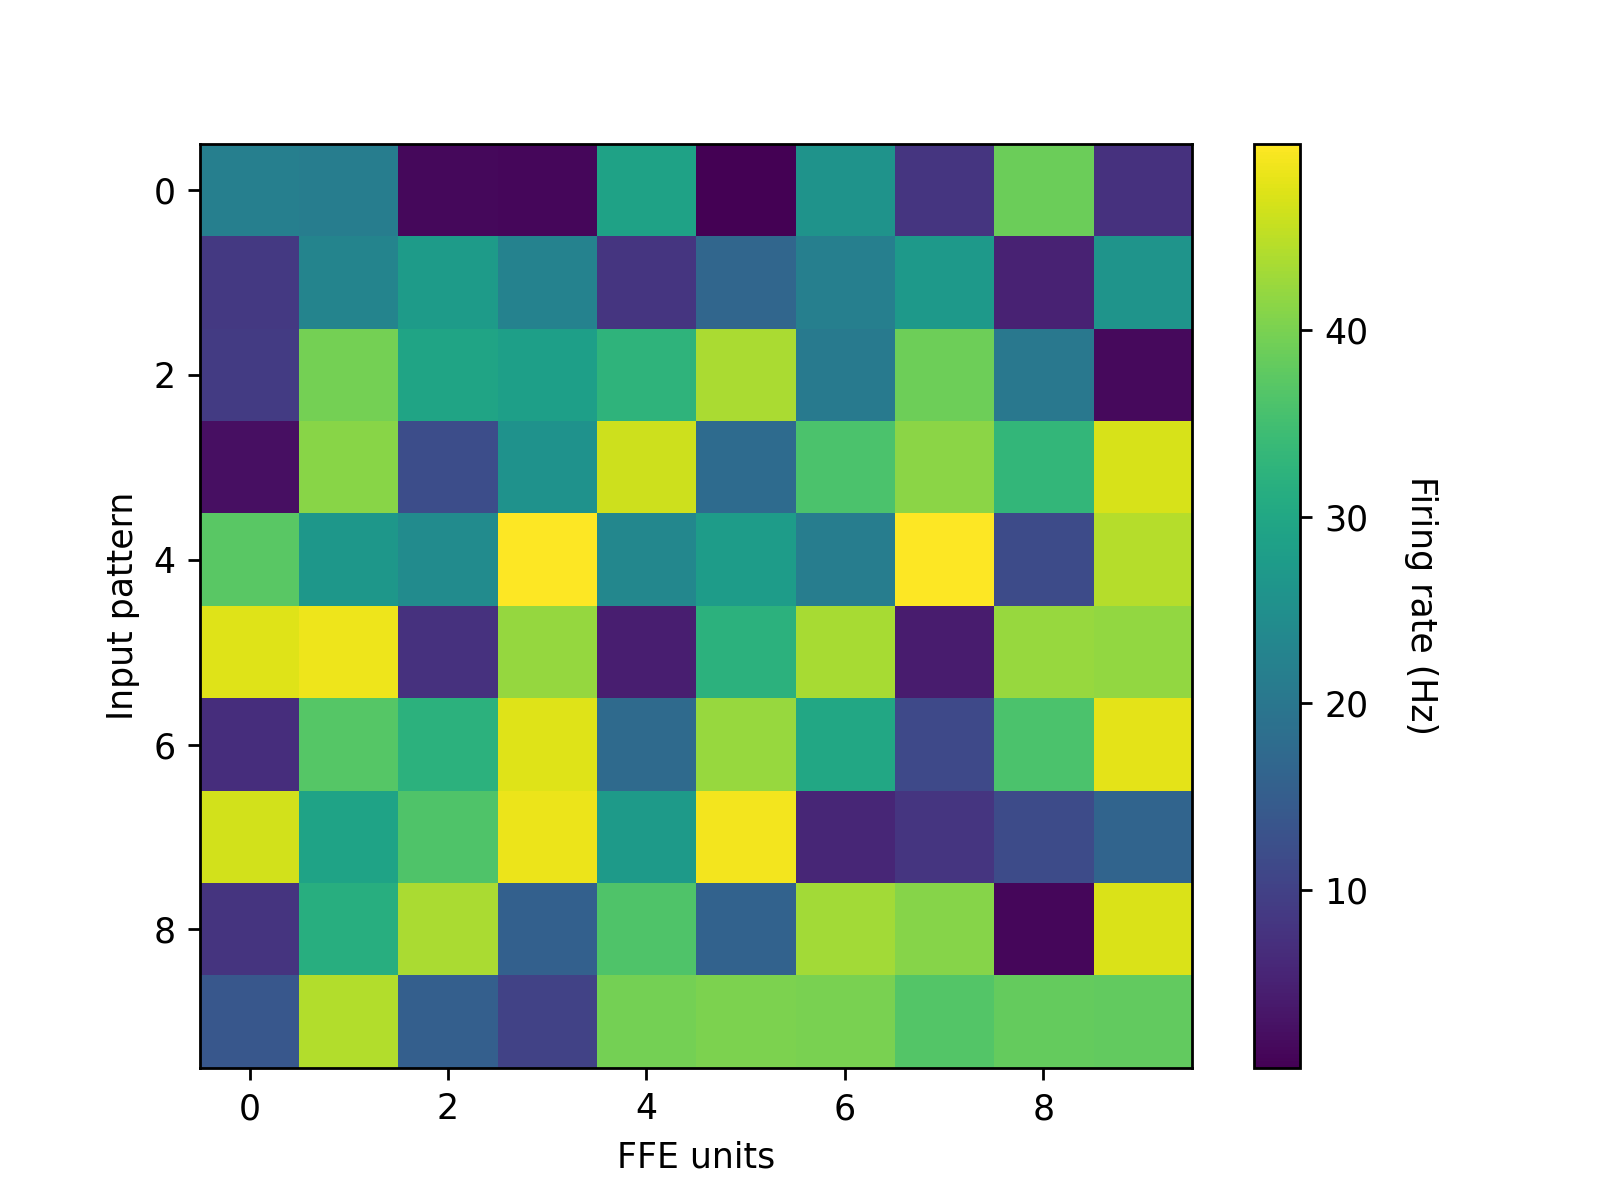

<IPython.core.display.Javascript object>


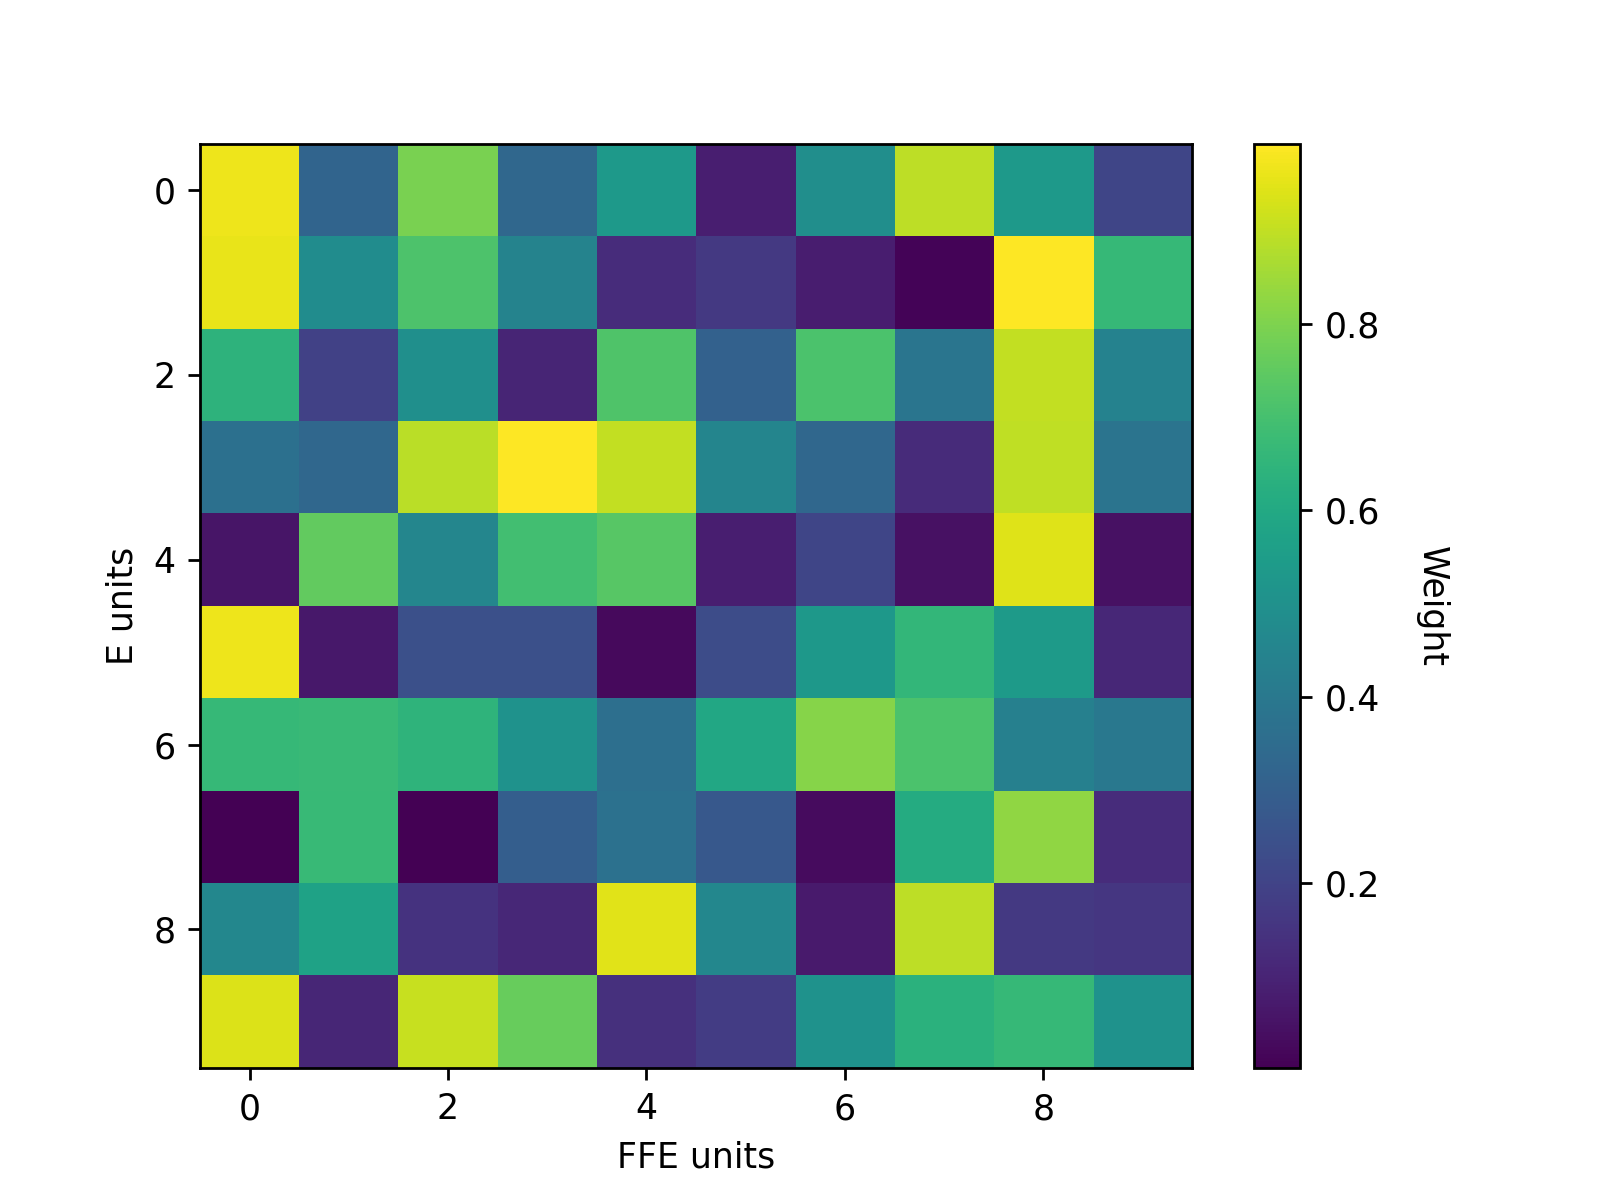

In [7]:
plt.figure()
plt.imshow(input_activities_dict['FFE'], aspect='auto')
plt.xlabel('FFE units')
plt.ylabel('Input pattern')
cbar = plt.colorbar()
cbar.set_label('Firing rate (Hz)', rotation=270., labelpad=20)

plt.figure()
plt.imshow(weight_init_dict['E']['FFE'], aspect='auto')
plt.xlabel('FFE units')
plt.ylabel('E units')
cbar = plt.colorbar()
cbar.set_label('Weight', rotation=270., labelpad=20)

In [13]:
def flatten_state_dicts(v_dict, i_dict):
    """
    :param v_dict: dict of voltages by population; {pop_name: 1d array of float}
    :param i_dict: dict of synaptic currents by projection; {post_pop_name: {pre_pop_name: 2d array of float}}
    :return: tuple; (list of float, nested dict: tuple of int indexes)
    """

    legend = dict()
    vals = []
    legend['v'] = dict()
    start = 0
    for pop_name in sorted(list(v_dict.keys())):
        vals.extend(v_dict[pop_name])
        end = len(vals)
        legend['v'][pop_name] = (start, end)
        start = end
    legend['i'] = defaultdict(dict)
    for post_pop_name in sorted(list(i_dict.keys())):
        for pre_pop_name in sorted(list(i_dict[post_pop_name].keys())):
            vals.extend(np.ravel(i_dict[post_pop_name][pre_pop_name]))
            end = len(vals)
            legend['i'][post_pop_name][pre_pop_name] = (start, end)
            start = end
    return vals, legend


def expand_states_to_dicts(vals, legend, num_cells_dict):
    """
    :param vals: list or array of float
    :param legend: nested dict: tuple of of int indexes
    :param num_cells_dict: dict of int
    :return: tuple; nested dicts of states by population
    """
    v_dict = dict()
    i_dict = defaultdict(dict)
    for pop_name in sorted(list(legend['v'].keys())):
        start = legend['v'][pop_name][0]
        end = legend['v'][pop_name][1]
        v_dict[pop_name] = vals[start:end]
    for post_pop_name in sorted(list(legend['i'].keys())):
        for pre_pop_name in sorted(list(legend['i'][post_pop_name].keys())):
            start = legend['i'][post_pop_name][pre_pop_name][0]
            end = legend['i'][post_pop_name][pre_pop_name][1]
            i_dict[post_pop_name][pre_pop_name] = vals[start:end].reshape((num_cells_dict[post_pop_name], num_cells_dict[pre_pop_name]))
    return v_dict, i_dict
            

def get_synapse_didt_dict(v_dict, i_dict, w_dict, a_dict, synapse_tau_dict, synapse_g_dict, synapse_v_reverse_dict):
    """
    :param v_dict: dict of cell voltages by population; {pop_name: 1d array of float}
    :param i_dict: dict of synaptic currents by projection; {post_pop_name: {pre_pop_name: 2d array of float}}
    :param w_dict: dict of synaptic weights by projection; {post_pop_name: {pre_pop_name: 2d array of float}}
    :param a_dict: dict of cell activities by population; {post_pop_name: {pre_pop_name: 1d array of float}}
    :param synapse_tau_dict: dict of synaptic decay time constants by projection; {post_pop_name: {pre_pop_name: float}}
    :param synapse_g_dict: dict of synaptic factor to convert rate to current; {post_pop_name: {pre_pop_name: float}}
    :param synapse_v_reverse_dict: dict of synaptic reversal potentials; {pre_pop_name: float}
    :return: dict of didt by projection; {post_pop_name: {pre_pop_name: 2d array of float}}
    """
    didt_dict = defaultdict(dict)
    for post_pop_name in v_dict:
        v = v_dict[post_pop_name]
        for pre_pop_name in i_dict[post_pop_name]:
            w = w_dict[post_pop_name][pre_pop_name]
            a = a_dict[pre_pop_name]
            v_reverse = synapse_v_reverse_dict[pre_pop_name]
            g = synapse_g_dict[post_pop_name][pre_pop_name]
            synapse_tau = synapse_tau_dict[post_pop_name][pre_pop_name]
            i = i_dict[post_pop_name][pre_pop_name]
            didt_dict[post_pop_name][pre_pop_name] = (-i + w * g * a * (v_reverse - v)) / synapse_tau
    return didt_dict


def get_cell_dvdt_dict(v_dict, i_dict, cell_v_rest_dict, cell_tau_dict, cell_r_inp_dict):
    """
    :param v_dict: dict of cell voltages by population; {pop_name: 1d array of float}
    :param i_dict: dict of synaptic currents by projection; {post_pop_name: {pre_pop_name: 2d array of float}}
    :param cell_v_rest_dict: dict of cell resting voltages by population; {pop_name: float}
    :param cell_tau_dict: dict of cell membrane decay time constants by population; {pop_name: float}
    :param cell_r_inp_dict: dict of cell input resistance by population; {pop_name: float}
    :return: dict of dvdt by population; {pop_name: 1d array of float}
    """    
    dvdt_dict = dict()
    for post_pop_name in v_dict:
        dvdt_dict[post_pop_name] = -(v_dict[post_pop_name] - cell_v_rest_dict[post_pop_name])
        for pre_pop_name in i_dict[post_pop_name]:
            dvdt_dict[post_pop_name] += cell_r_inp_dict[post_pop_name] * np.sum(i_dict[post_pop_name][pre_pop_name], axis=1)
        dvdt_dict[post_pop_name] /= cell_tau_dict[post_pop_name]
    
    return dvdt_dict


def simulate_network(t, states, state_legend, num_cells_dict, input_pattern_index, input_activities_dict, w_dict, cell_v_rest_dict, cell_peak_rate_dict, 
                     cell_tau_dict, cell_r_inp_dict, synapse_tau_dict, synapse_g_dict, synapse_v_reverse_dict):
    """
    :param t: float
    :param states: 1d array of float
    :param state_legend: nested dict: tuple of int indexes
    :param num_cells_dict: dict of int
    :param input_pattern_index: int
    :param input_activities_dict: dict of input activities by population; {pop_name: float}
    :param w_dict: dict of synaptic weights by projection; {post_pop_name: {pre_pop_name: 2d array of float}}
    :param cell_v_rest_dict: dict of cell resting voltages by population; {pop_name: float}
    :param cell_peak_rate_dict: dict of cell peak firing rates by population; {pop_name: float}
    :param cell_tau_dict: dict of cell membrane decay time constants by population; {pop_name: float}
    :param cell_r_inp_dict: dict of cell input resistance by population; {pop_name: float}
    :param synapse_tau_dict: dict of synaptic decay time constants by projection; {post_pop_name: {pre_pop_name: float}}
    :param synapse_g_dict: dict of synaptic factor to convert rate to current; {post_pop_name: {pre_pop_name: float}}
    :param synapse_v_reverse_dict: dict of synaptic reversal potentials; {pre_pop_name: float}
    :return: 1d array of float
    """
    v_dict, i_dict = expand_states_to_dicts(states, state_legend, num_cells_dict)
    a_dict = dict()
    for pop_name in input_activities_dict:
        a_dict[pop_name] = input_activities_dict[pop_name][input_pattern_index]
    for pop_name in v_dict:
        a_dict[pop_name] = relu(v_dict[pop_name], peak_rate=cell_peak_rate_dict[pop_name])
    
    dvdt_dict = get_cell_dvdt_dict(v_dict, i_dict, cell_v_rest_dict, cell_tau_dict, cell_r_inp_dict)
    didt_dict = get_synapse_didt_dict(v_dict, i_dict, w_dict, a_dict, synapse_tau_dict, synapse_g_dict, synapse_v_reverse_dict)
    dstatesdt, _ = flatten_state_dicts(dvdt_dict, didt_dict)
    
    return dstatesdt

In [14]:
v_init_dict = {'E': np.ones(num_cells_dict['E']) * cell_v_rest_dict['E']}
i_init_dict = defaultdict(dict)
for post_pop_name in weight_init_dict:
    for pre_pop_name in weight_init_dict[post_pop_name]:
        i_init_dict[post_pop_name][pre_pop_name] = np.zeros_like(weight_init_dict[post_pop_name][pre_pop_name])

input_pattern_index = 0
a_init_dict = dict()
for pop_name in v_init_dict:
    a_init_dict[pop_name] = relu(v_init_dict[pop_name], peak_rate=cell_peak_rate_dict[pop_name])
for pop_name in input_activities_dict:
    a_init_dict[pop_name] = input_activities_dict[pop_name][input_pattern_index]

states, state_legend = flatten_state_dicts(v_init_dict, i_init_dict)

<IPython.core.display.Javascript object>


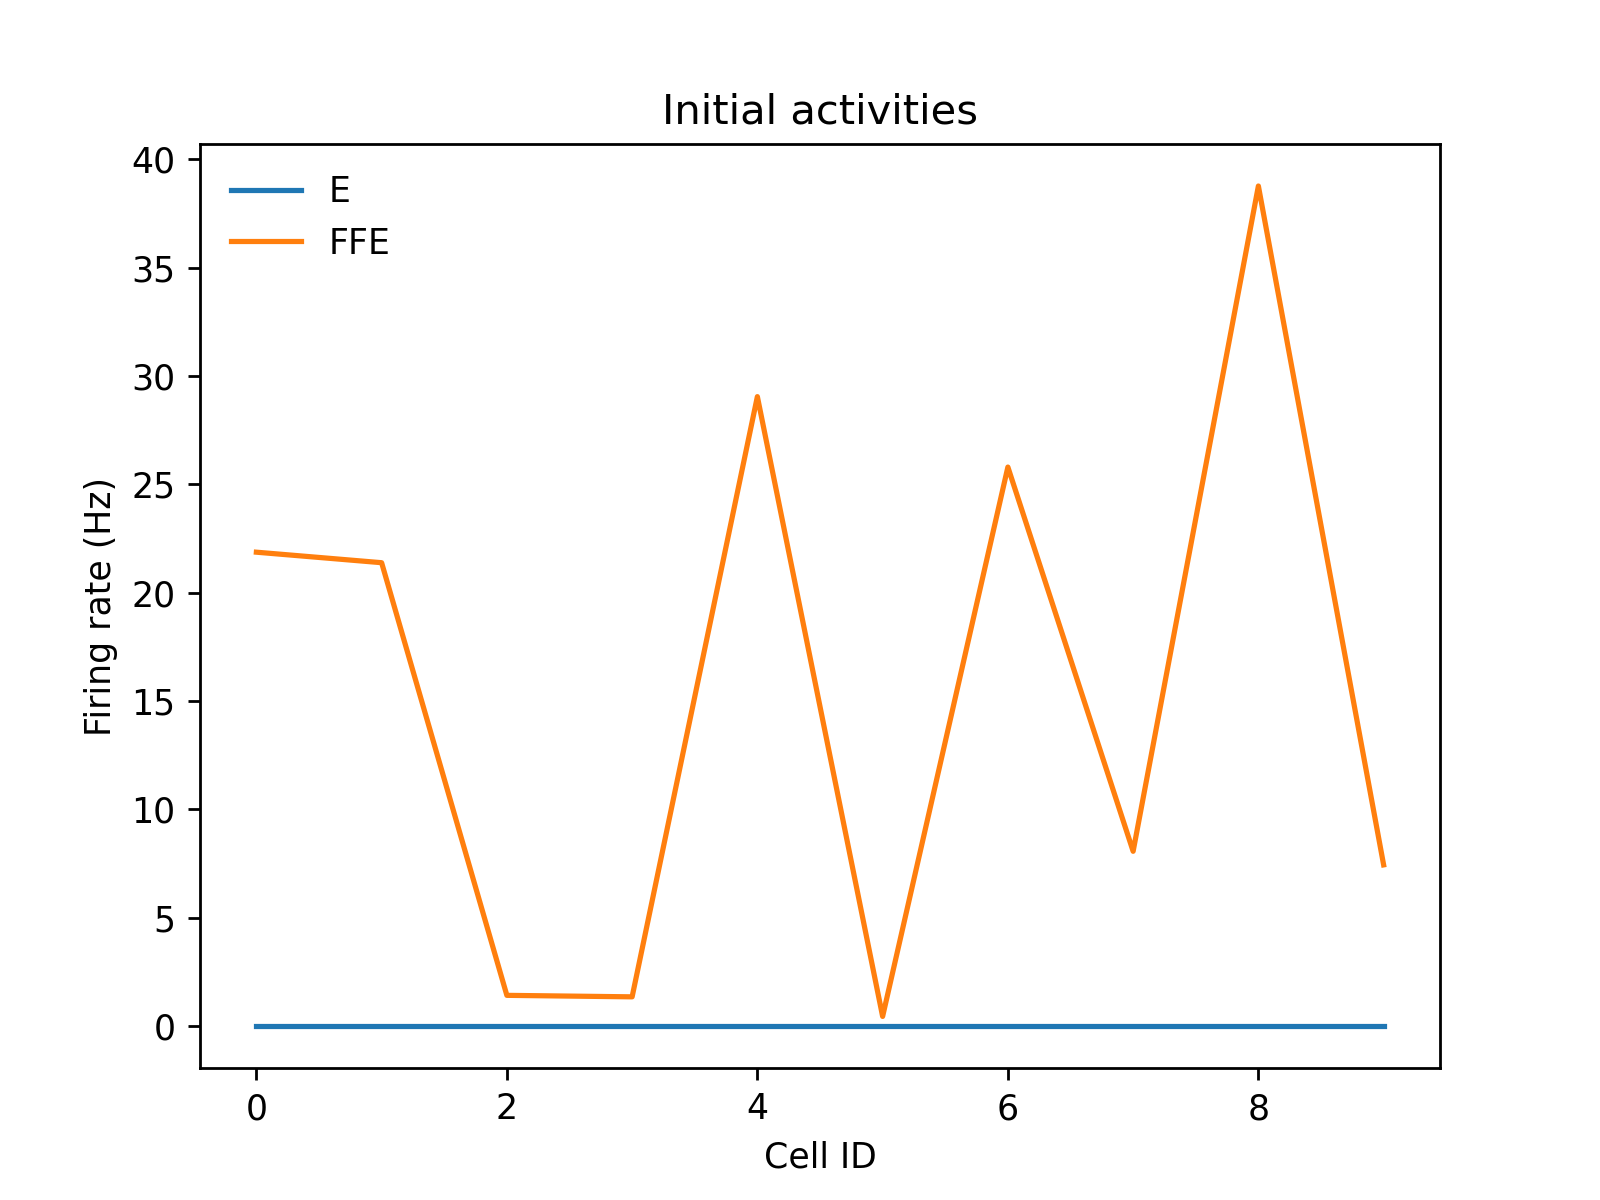

In [15]:
plt.figure()
plt.plot(a_init_dict['E'], label='E')
plt.plot(a_init_dict['FFE'], label='FFE')
plt.xlabel('Cell ID')
plt.ylabel('Firing rate (Hz)')
plt.title('Initial activities')
plt.legend(loc='best', frameon=False)

In [16]:
didt_dict = get_synapse_didt_dict(v_init_dict, i_init_dict, weight_init_dict, a_init_dict, synapse_tau_dict, synapse_g_dict, synapse_v_reverse_dict)

dvdt_dict = get_cell_dvdt_dict(v_init_dict, i_init_dict, cell_v_rest_dict, cell_tau_dict, cell_r_inp_dict)

In [17]:
didt_dict['E']['FFE']

array([[2.96141026e+00, 9.66057883e-01, 1.57202644e-01, 6.27821896e-02,
        2.19303604e+00, 5.21474439e-03, 1.77312459e+00, 1.01117486e+00,
        2.91465914e+00, 2.19254449e-01],
       [2.94131253e+00, 1.44905653e+00, 1.41699465e-01, 8.40897074e-02,
        5.15786923e-01, 1.02168246e-02, 2.96336456e-01, 1.38032797e-02,
        5.38946683e+00, 6.92851643e-01],
       [1.97125984e+00, 5.78088583e-01, 9.77231538e-02, 1.98423770e-02,
        2.92928756e+00, 1.90991790e-02, 2.56636015e+00, 4.35838074e-01,
        4.88530916e+00, 4.59059637e-01],
       [1.12543773e+00, 9.93901169e-01, 1.76297983e-01, 1.87101730e-01,
        3.66122057e+00, 2.79392205e-02, 1.19705097e+00, 1.38205483e-01,
        4.87476106e+00, 4.00142594e-01],
       [1.78269665e-01, 2.25588141e+00, 9.01215170e-02, 1.30607749e-01,
        2.98376747e+00, 5.32004612e-03, 7.48902288e-01, 5.38747914e-02,
        5.13462217e+00, 4.83489794e-02],
       [2.96409667e+00, 1.90493476e-01, 4.85255427e-02, 4.62694754e-02,
   

In [19]:
states_init, state_legend = flatten_state_dicts(v_init_dict, i_init_dict)
input_pattern_index = 0

duration = 1.  # sec
num_time_steps = 300
t = np.linspace(0., duration, num_time_steps)
sol = solve_ivp(simulate_network, [0., duration], states_init, 
                args=(state_legend, num_cells_dict, input_pattern_index, input_activities_dict, weight_init_dict, cell_v_rest_dict, cell_peak_rate_dict,
                      cell_tau_dict, cell_r_inp_dict, synapse_tau_dict, synapse_g_dict, synapse_v_reverse_dict), dense_output=True)

states = sol.sol(t)

In [20]:
states.shape

(110, 300)

In [21]:
print(states[:10, -1])

[-59.42335309 -59.99170846 -57.92582141 -58.93432104 -59.90583429
 -62.15162904 -59.41925866 -62.12704962 -61.91031907 -60.66087308]


<IPython.core.display.Javascript object>


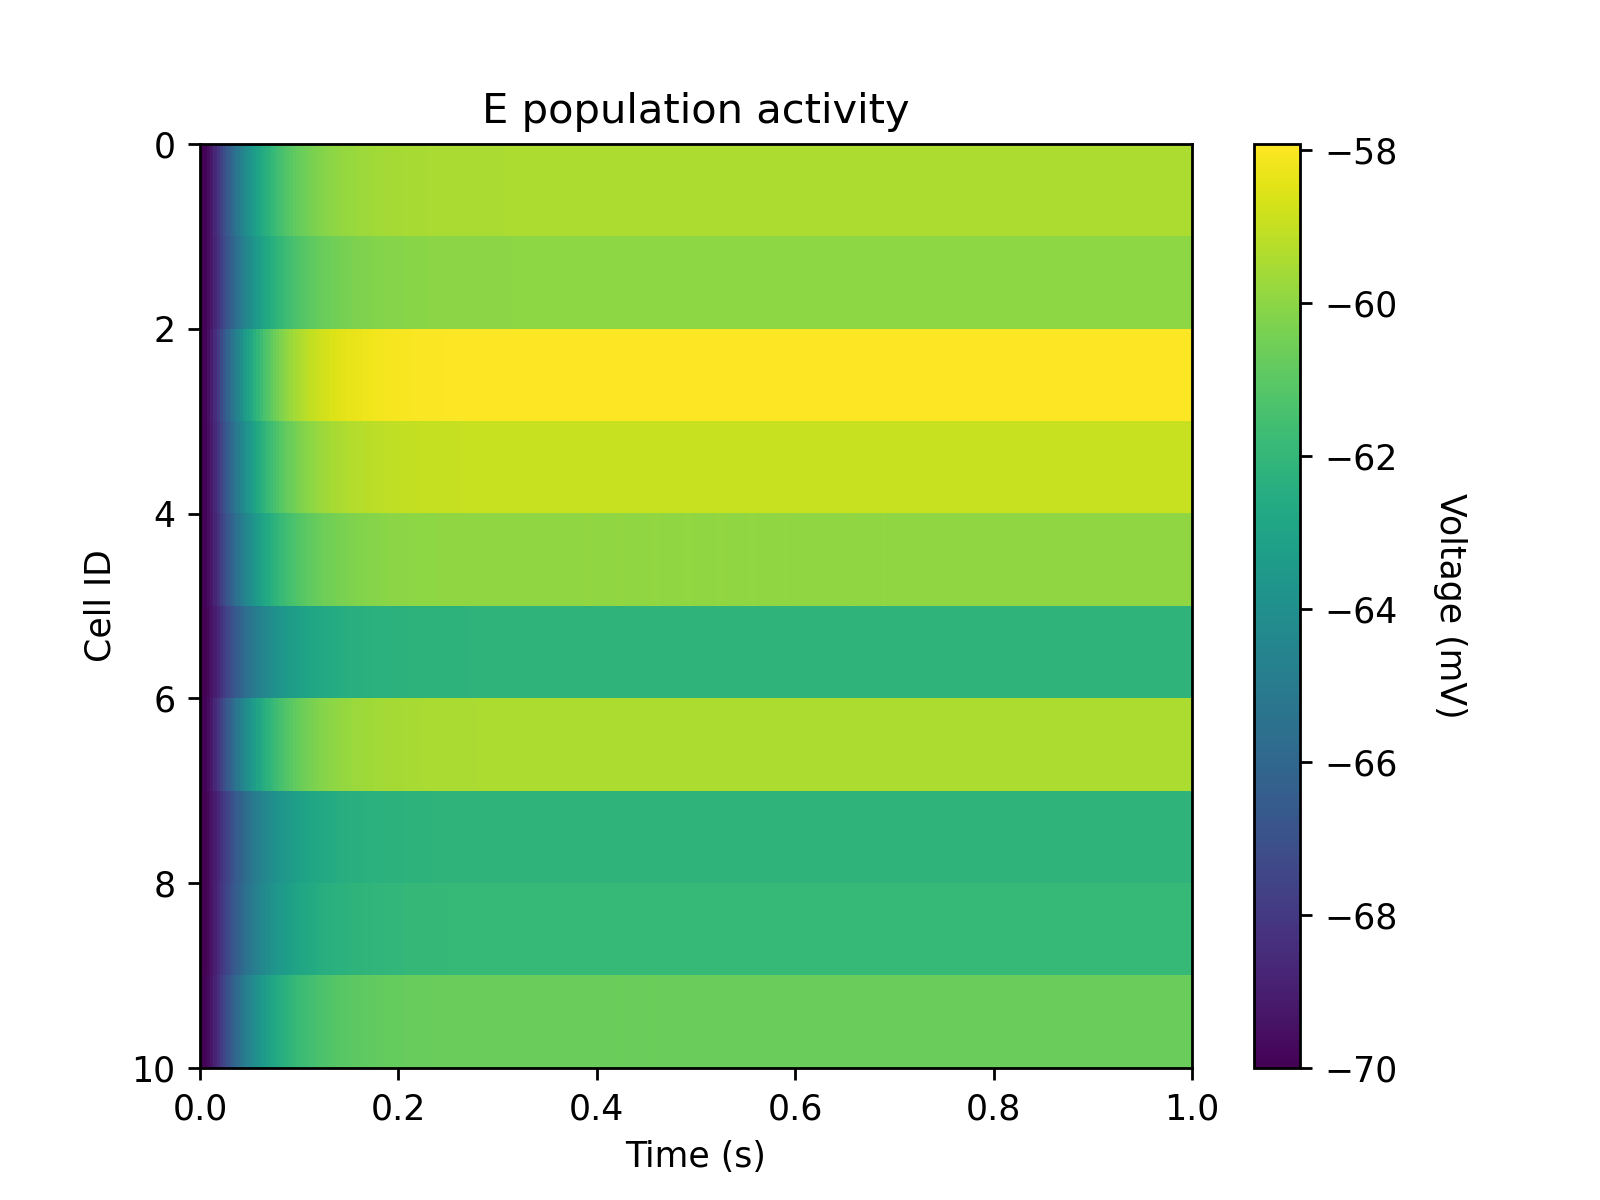

In [22]:
plt.figure()

plt.imshow(states[:10,:], aspect='auto', extent=(0., duration, 10, 0))
plt.xlabel('Time (s)')
plt.ylabel('Cell ID')
plt.title('E population activity')
cbar = plt.colorbar()
cbar.set_label('Voltage (mV)', rotation=270., labelpad=20.)
